<a href="https://colab.research.google.com/github/BlackCurrantDS/DBSE_Project/blob/main/Cancer_RPP_Evaluation_baselineClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This norebook genearted rules wiht RP-growth and the evaluate on various classififers.

The output file output.txt needs to be manually mapped in json format and needs to be converted into rule since this implmenation takes number as input.

In [271]:
import pandas as pd
inputfilepath = "/content/breast_train_transactions.txt" #This need to be in number format
inputTestfilepath = "/content/breast_test_transactions.txt"
file_path = "/content/"
#originalfile = "/content/drive/MyDrive/Hep_DataSet/hep_data_original.csv"
clus = "RPP"
d = '/content/' #specify the folder all the input and output files are

Evaluation

In [272]:
from sklearn.metrics.ranking import roc_curve, auc
from sklearn.metrics.classification import f1_score
from sklearn.svm.classes import SVC
from sklearn.ensemble.forest import RandomForestClassifier

In [273]:
class AssociationRule:
    def __init__(self, left, right):
        self.left_items = left
        self.right_items = right
        self.scores = []
        
    def length(self):
        return len(self.left_items) + len(self.right_items)
     
    def score(self, index):
        return self.scores[index]
    
    def lhs_string(self):
        return itemset_2_string(self.left_items)
        
    def rhs_string(self):
        return itemset_2_string(self.right_items)
    
    def serialize(self):
        left_key = self.lhs_string()
        right_key = self.rhs_string()
        return left_key + ">" + right_key
    
    @staticmethod        
    def string_2_rule(s):
        subStrings = s.split(">")
        print(subStrings)
        print("subStrings[0]",subStrings[0])
        print("subStrings[1]",subStrings[1])
        left = string_2_itemset(subStrings[0].strip())
        right = string_2_itemset(subStrings[1].strip())
        #print("AssociationRule(left, right",AssociationRule(left, right))
        return AssociationRule(left, right)

    def append_score(self, score):
        self.scores.append(score)
        
    def get_itemset(self):
        itemset = []
        itemset.extend(self.left_items)
        itemset.extend(self.right_items)
        itemset.sort()
        return itemset
        
        
    def rule_itemset_2_string(self):
        itemset = self.get_itemset()
        return itemset_2_string(itemset)
    
    def compute_basic_probs(self,frequent_itemsets, nTransactions):  
        
        left = frequent_itemsets[self.lhs_string()]
        right = frequent_itemsets[self.rhs_string()]
        
        both = frequent_itemsets[self.rule_itemset_2_string()]
        
        vector = {}
        
        ''' 1. P(A)'''
        p_A = left/nTransactions
        vector['A'] = p_A
        
        ''' 2. P(B)'''
        p_B = right/nTransactions
        vector['B'] = p_B
        
        ''' 3. P(~A)'''
        p_not_A = 1 - p_A
        vector['~A'] = p_not_A
        
        ''' 4. P(~B)'''
        p_not_B = 1 - p_B
        vector['~B'] = p_not_B
        
        ''' 5. P(AB) '''
        p_A_and_B = both/nTransactions
        vector['AB'] = p_A_and_B
        
        ''' 6. P(~AB)'''
        p_not_A_and_B = (right - both)/nTransactions
        vector['~AB'] = p_not_A_and_B
        
        ''' 7. P(A~B)'''
        p_A_and_not_B = (left - both)/nTransactions
        vector['A~B'] = p_A_and_not_B
        
        ''' 8. P(~A~B)'''
        p_not_A_and_not_B = 1 - (left + right - both)/nTransactions
        vector['~A~B'] = p_not_A_and_not_B 
        
        '''
        9. P(A|B)
        '''
        p_A_if_B = p_A_and_B / p_B
        vector['A|B'] = p_A_if_B
        
        '''
        10. P(~A|~B)
        '''
        p_not_A_if_not_B = p_not_A_and_not_B / p_not_B
        vector['~A|~B'] = p_not_A_if_not_B
        
        '''
        11. P(A|~B)
        '''
        p_A_if_not_B = p_A_and_not_B/p_not_B
        vector['A|~B'] = p_A_if_not_B
        
        '''
        12. p(~A|B)
        '''
        p_not_A_if_B = p_not_A_and_B / p_B
        vector['~A|B'] = p_not_A_if_B
        
        '''
        13. P(B|A)
        '''
        p_B_if_A = p_A_and_B / p_A
        vector['B|A'] = p_B_if_A
        
        '''
        14. P(~B|~A)
        '''
        p_not_B_if_not_A = p_not_A_and_not_B / p_not_A
        vector['~B|~A'] = p_not_B_if_not_A
        
        '''
        15. P(B|~A)
        '''
        p_B_if_not_A = p_not_A_and_B/p_not_A
        vector['B|~A'] = p_B_if_not_A
        
        '''
        16. p(~B|A)
        '''
        p_not_B_if_A = p_A_and_not_B / p_A
        vector['~B|A'] = p_not_B_if_A
        
        return vector
    
    def is_redundant_(self, bits, k, itemset, freq_itemset_dict): 
        '''
        Run out of items --> create rule and check format criterion
        '''
        if k >= len(itemset):
            items_1 = []
            items_2 = []
            for index in range(len(bits)):
                if bits[index] == True:
                    items_1.append(itemset[index])
                else:
                    items_2.append(itemset[index])
            for item in items_2:
                rule = AssociationRule(items_1, [item])
                confidence = freq_itemset_dict.getConfidence(rule)
                if confidence == 1: return True
            return False 
      
        value_domain = [True, False]
        for value in value_domain:
            bits[k] = value
            checker = self.is_redundant_(bits, k+1, itemset, freq_itemset_dict)
            if checker == True: return True
            bits[k] = True    
        return False
    
    '''
    Expand an item-set with equivalent items.
    '''
    def is_redundant(self, freq_itemset_dict):
        bits = [True for _ in self.left_items]
        checker = self.is_redundant_(bits, 0, self.left_items, freq_itemset_dict)
        if checker == True: return True
        
        bits =  [True for _ in self.right_items]
        return self.is_redundant_(bits, 0, self.right_items, freq_itemset_dict)
    
    def satisfy_rule(self, itemset, is_lhs = True):
        condition = self.left_items
        print("condition",condition)
        if is_lhs == False: condition = self.right_items
        #print("is_lhs",is_lhs)
        #print("condition",condition)
        #print("len(condition)",len(condition))
        #print("len(itemset)",len(itemset))
        if len(condition) > len(itemset) or len(itemset) == 0:
            return False
        for item in condition:
            #print("item",item)
            if item not in itemset:
                #print("this item is not in itemset", item)
                return False
            else:
                print("this item is present in itemset", item)
        return True
    

In [274]:
class RelationArray2D(object):
    '''
    classdocs
    '''

    def __init__(self, item_dict, relation_values):
        '''
        Constructor
        '''
        self.item_dict = item_dict
        self.relation_matrix = relation_values
        
        
    def get_value(self, item1, item2):
        i = self.item_dict[item1]
        j = self.item_dict[item2]
        return self.relation_matrix[i, j]
    
    def get_items(self):
        return self.item_dict.keys()
        
    def get_index(self, item):
        return self.item_dict[item]
    
class RelationArray1D(object):
    '''
    classdocs
    '''

    def __init__(self, item_dict, values):
        '''
        Constructor
        '''
        self.item_dict = item_dict
        self.values = values
        
        
    def get_value_at(self, index):
        return self.values[index]
    
    def get_items(self):
        return self.item_dict.keys()
        
    def get_value(self, item):
        return self.item_dict[item]

In [275]:
# Transaction databases, each transaction is a set of items
import numpy as np
from scipy import sparse
from scipy import stats


class DataSet:
    def __init__(self):
        self.current = 0
        self.train_data = []
        self.data_labels = []
        
    
    def __iter__(self):
        return iter(self.train_data)
                
    def size(self):
        return len(self.train_data)
    
    def get_transaction(self, index):
        return self.train_data[index]
    
    def clear(self):
        self.train_data.clear()
        
    def add_transaction(self, t):
        return self.train_data.append(t) 
        
    '''
    Load data set from a file. The input file must be formated in CSV (comma separated)
    class_index is used in the case of data-set with labels. 
    '''
    def load(self, file_path, class_index = -1, has_header = False):
        self.train_data = []
        if class_index != -1: self.data_labels = []
        
        with open(file_path, "r") as text_in_file:
            if has_header == True:
                text_in_file.readline()
                
            for line in text_in_file:
                #print("dataset script line", line)
                transaction = [x.strip() for x in line.split(',')]
                transaction = list(filter(None, transaction))
                #print("datset script transaction" , transaction)
                
                if (class_index != -1):
                    self.data_labels.append(transaction[class_index])
                    del transaction[class_index]
                
                self.train_data.append(list(set(transaction)))
        print("Loading done")
    '''
    Return number of classes in data (if have).
    '''            
    def number_of_classes(self):
        if self.data_labels == None: return 0
        return len(set(self.data_labels))

    def convert_data_labels(self, inlier_name):
        Y_train = np.zeros(len(self.data_labels))
        for i in range(Y_train.shape[0]):
            if self.data_labels[i] == inlier_name:
                Y_train[i] = 1
            else: 
                Y_train[i] = -1
        return Y_train

    def convert_2_binary_format_with(self, items_dict, classes_dict = None):
        n_items = len(items_dict)
        X_train = np.zeros((self.size(), n_items))
        
        k = 0
        for transaction in self.train_data:
            for item in transaction:
                if item not in items_dict: 
                    print('not in features...')
                    continue
                i = items_dict[item]
                X_train[k, i] = 1.0
            k += 1
            
        Y_train = []
        if classes_dict is not None:
            for label in self.data_labels:
                if label not in classes_dict:
                    print('not in classes')
                    Y_train.append(-1)
                else:
                    Y_train.append(classes_dict[label]) 
        return X_train, np.array(Y_train)        
    
    def get_items_dict_(self):
        attr_dict = {}
        #check existing data
        for transaction in self.train_data:
            for index in range (len(transaction)):
                item_name = transaction[index]
                if item_name not in attr_dict:
                    attr_dict[item_name] = True
        return attr_dict
    
    def get_class_list_(self):
        # Sort items and classes in alphabet order.
        return sorted(set(self.data_labels))
        
        

    '''
    Convert transaction data into binary format
    '''
    def convert_2_binary_format(self):
        
        attr_dict = self.get_items_dict_()
        print("convert_2_binary_format attr_dict", attr_dict)
        """
        {'a6@3': True, 'a7@left': True, 'a9@no': True, 'a3@30-34': True, 'a1@30-39': True, 'class@no': True, 'a5@no': True, 'a4@0-2': True, 'a2@premeno': True, 'a8@left_low': True, 'a8@right_up': True, 'a3@20-24': True, 'a7@right': True, 'a1@40-49': True, 'a6@2': True, 'a8@left_up': True, 'a2@ge40': True, 'a1@60-69': True, 'a3@15-19': True, 'a8@right_low': True, 'a3@0-4': True, 'a3@25-29': True, 'a1@50-59': True, 'a3@50-54': True, 'a8@central': True, 'a6@1': True, 'a3@10-14': True, 'a2@lt40': True, 'a3@40-44': True, 'a3@35-39': True, 'a1@70-79': True, 'a3@5-9': True, 'a9@yes': True, 'a5@yes': True, 'a4@6-8': True, 'a4@9-11': True, 'a4@3-5': True, 'a3@45-49': True, 'a5@?': True, 'a4@15-17': True, 'a4@12-14': True, 'class@yes': True, 'a8@?': True, 'a4@24-26': True}
        
        
        """
         
        # Sort items and classes in alphabet order.
        classes_list = sorted(set(self.data_labels))
        items_list = sorted(attr_dict.keys())
        
        classes_dict = {classes_list[i] : i for i in range(len(classes_list))}
        attr_dict = {items_list[i] : i for i in range(len(items_list))}
        
        #Generate binary matrix (X_train) and array of labels(Y_train)
        X_train, Y_train = self.convert_2_binary_format_with(attr_dict, classes_dict)
                
        return RelationArray2D(attr_dict, sparse.csr_matrix(X_train)), RelationArray1D(classes_dict, np.array(Y_train))

                
                


In [276]:
train_data_set = DataSet()

In [277]:
train_data_set.load(inputfilepath, 0, has_header = False)

Loading done


In [278]:
X_train, Y_train = train_data_set.convert_2_binary_format()

convert_2_binary_format attr_dict {'a2@premeno': True, 'a6@3': True, 'a7@left': True, 'a1@30-39': True, 'a5@no': True, 'a4@0-2': True, 'a8@left_low': True, 'a9@no': True, 'a3@30-34': True, 'a8@right_up': True, 'a6@2': True, 'a3@20-24': True, 'a7@right': True, 'a1@40-49': True, 'a3@15-19': True, 'a2@ge40': True, 'a8@left_up': True, 'a1@60-69': True, 'a3@0-4': True, 'a8@right_low': True, 'a1@50-59': True, 'a3@25-29': True, 'a3@50-54': True, 'a8@central': True, 'a2@lt40': True, 'a3@10-14': True, 'a6@1': True, 'a3@40-44': True, 'a3@35-39': True, 'a1@70-79': True, 'a3@5-9': True, 'a5@yes': True, 'a4@6-8': True, 'a9@yes': True, 'a4@9-11': True, 'a4@3-5': True, 'a3@45-49': True, 'a5@?': True, 'a4@15-17': True, 'a4@12-14': True, 'a8@?': True, 'a4@24-26': True}


In [279]:
Y_train.item_dict

{'class@no': 0, 'class@yes': 1}

In [280]:
test_data_set = DataSet()
test_data_set.load(inputTestfilepath, 0, has_header = False)
Xtest, Ytest = test_data_set.convert_2_binary_format_with(X_train.item_dict, Y_train.item_dict)
Ytest = Ytest.flatten()

Loading done
not in features...


In [281]:
class_count = train_data_set.number_of_classes()

In [282]:
class_count

2

In [283]:
import json
import numpy as np

class IOHelper:

    @staticmethod
    def write_file_in_lines(file_name, data, header = None):
        with open(file_name, "w") as text_file:
            if header is not None:
                text_file.write(header)
                text_file.write('\n')
            for transaction in data:
                text_file.write(transaction)
                text_file.write('\n')
    
    @staticmethod        
    def read_file_in_lines(inputfile, has_header = False):
        data = []
        with open(inputfile, "r") as text_file:
            file_iter = iter(text_file)
            if has_header == True:
                next(file_iter)
            
            for line in file_iter:
                data.append(line.strip())
        return data
    
    @staticmethod
    def read_ranking_file(input_file):
        patterns = []
        ranking = []
        k = 0
        with open(input_file, "r") as text_file:
            for line in text_file:
                subStrings = line.split(';')
                rule_key = subStrings[0].strip()
                patterns.append(rule_key)
                ranking.append([])
                for v in subStrings[1:]:
                    r = int(v)
                    ranking[k].append(r)
                
                k += 1
                if k % 1000 == 0: print(str(k))
        return patterns, np.array(ranking)
    
    @staticmethod 
    def save_as_json_format(file_name, o):
        with open (file_name, 'w') as text_file:
            json.dump(o, text_file)
            
    @staticmethod 
    def save_as_json_format_in_line(file_name, o):
        with open (file_name, 'w') as text_file:
            #json.dump(o, text_file)
            for item in o:
                line = json.dumps(item)
                text_file.write(line)
                text_file.write('\n')
            
    @staticmethod        
    def load_json_object(file_name):
        with open(file_name, 'r') as text_file:
            o = json.load(text_file)
            return o
    
    @staticmethod    
    def write_matrix(file_name, matrix):
        with open(file_name, "w") as text_file:
            for line in matrix:
                text_file.write(','.join(str(x) for x in line.tolist()))
                text_file.write('\n')
    
    @staticmethod
    def write_list_of_tuples(file_name, tuples_list):
        with open(file_name, 'w') as writer:
            for rule in tuples_list:
                writer.write(str(rule))
                writer.write('\n')

In [284]:
unexpected_rules = IOHelper.load_json_object(file_path+"unexpected_rule_file_json")

In [285]:
def filter_association_rules(unexpected_rules, delta_1 = 0):
    rules = []
    for x in unexpected_rules:
        print(x)
        print(x[0])
         
        rules.append(AssociationRule.string_2_rule(x[0]))
    return rules

In [286]:
def string_2_itemset(key):
    if key == '':
        return []
    else: 
        return key.split(',')

def itemset_2_string(itemset):
    return ",".join(itemset)

def merge_itemsets(itemset_1, itemset_2):
    merged_items = []
    merged_items.extend(itemset_1)
    merged_items.extend(itemset_2)
    merged_items = list(set(merged_items))
    merged_items = sorted(merged_items)
    
    return merged_items

def get_full_path(prefix, file_name):
    if prefix == '': return file_name
    return prefix + '//' + file_name


In [287]:
refined_unexpected_rules = filter_association_rules(unexpected_rules)

['a2@ge40,a4@3-5,a5@no,a9@no>class@yes', 1.0, [['a2@ge40,a5@no,a9@no>class@no', 0.8788212007857173, 1.0, 0.8235294117647058]]]
a2@ge40,a4@3-5,a5@no,a9@no>class@yes
['a2@ge40,a4@3-5,a5@no,a9@no', 'class@yes']
subStrings[0] a2@ge40,a4@3-5,a5@no,a9@no
subStrings[1] class@yes
['a1@50-59,a2@ge40,a3@30-34,a6@3,a7@left,a9@no>class@yes', 1.0, [['a1@50-59,a2@ge40,a7@left,a9@no>class@no', 0.8373564003526224, 1.0, 0.8], ['a2@ge40,a7@left,a9@no>class@no', 0.8063165178857923, 1.0, 0.8571428571428571]]]
a1@50-59,a2@ge40,a3@30-34,a6@3,a7@left,a9@no>class@yes
['a1@50-59,a2@ge40,a3@30-34,a6@3,a7@left,a9@no', 'class@yes']
subStrings[0] a1@50-59,a2@ge40,a3@30-34,a6@3,a7@left,a9@no
subStrings[1] class@yes
['a2@ge40,a4@3-5,a5@no>class@yes', 1.0, [['a2@ge40,a5@no,a9@no>class@no', 0.7989617927178547, 0.6666666666666666, 0.8235294117647058], ['a2@ge40,a5@no,a7@left>class@no', 0.7195768942672238, 0.5, 0.8333333333333334]]]
a2@ge40,a4@3-5,a5@no>class@yes
['a2@ge40,a4@3-5,a5@no', 'class@yes']
subStrings[0] a2@ge

In [288]:
print('svm testing...')
svc_model = SVC(class_weight='balanced')
svc_model.fit(X_train.relation_matrix, Y_train.values.flatten())

svm testing...


SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [289]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

def refine_with_unexpectedness(data_set, classes_dict, preY, Ytrue, unexpected_rules, model, clus):
    
    print('Refine with unexpected rules...')
    y_pred = np.copy(preY)
    for i in range(data_set.size()):
        x = data_set.get_transaction(i)
        print("x is ",x)
        for r in unexpected_rules:
            #print(r)
            if r.satisfy_rule(x, is_lhs = True):
                print("r.satisfy_rule(x, is_lhs = True)", r.satisfy_rule(x, is_lhs = True))
                label = r.right_items[0]
                print("label is ",label)
                y_pred[i] = classes_dict[label]
                print("y pred for i is",y_pred[i])
    x_axis_labels = ['No', 'Yes']
    y_axis_labels = ['No', 'Yes']
    print(f1_score(Ytrue, y_pred, average=None))
    print(confusion_matrix(Ytrue, y_pred))
    c=confusion_matrix(Ytrue, y_pred)
    df_cm = pd.DataFrame(c, range(2), range(2))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels=x_axis_labels, yticklabels=y_axis_labels) # font size

    
    if (data_set.number_of_classes() <= 2):
        fpr, tpr, _ = roc_curve(Ytrue, y_pred.flatten())
        print(auc(fpr, tpr))

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")  
    plt.savefig(file_path+"Refined_"+model+"_"+clus+"_"+"confusion_matrix.png")
    plt.show()

SVM

In [290]:
svc_y_pred = svc_model.predict(Xtest)
print(f1_score(Ytest, svc_y_pred, average=None))
if (class_count <= 2):
  fpr, tpr, _ = roc_curve(Ytest, svc_y_pred.flatten())    
  print(auc(fpr, tpr))

[0.8   0.625]
0.7321428571428572


Refine with unexpected rules...
x is  ['a3@20-24', 'a7@left', 'a6@1', 'a5@no', 'a4@0-2', 'a2@ge40', 'a8@left_low', 'a9@no', 'a1@60-69']
condition ['a2@ge40', 'a4@3-5', 'a5@no', 'a9@no']
this item is present in itemset a2@ge40
condition ['a1@50-59', 'a2@ge40', 'a3@30-34', 'a6@3', 'a7@left', 'a9@no']
condition ['a2@ge40', 'a4@3-5', 'a5@no']
this item is present in itemset a2@ge40
condition ['a2@ge40', 'a4@3-5', 'a5@no', 'a8@left_low']
this item is present in itemset a2@ge40
condition ['a6@3', 'a7@right', 'a8@right_up', 'a9@no']
condition ['a2@ge40', 'a4@3-5', 'a6@3', 'a8@left_low']
this item is present in itemset a2@ge40
condition ['a2@ge40', 'a3@30-34', 'a4@3-5', 'a5@no']
this item is present in itemset a2@ge40
condition ['a1@50-59', 'a2@ge40', 'a3@30-34', 'a6@3', 'a9@no']
condition ['a1@50-59', 'a3@30-34', 'a6@3', 'a7@left', 'a9@no']
condition ['a3@25-29', 'a5@no', 'a6@3', 'a7@left']
condition ['a2@ge40', 'a3@30-34', 'a4@3-5']
this item is present in itemset a2@ge40
condition ['a4@3-5'

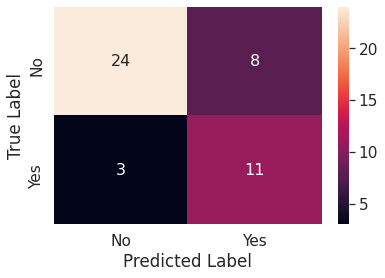

In [291]:

refine_with_unexpectedness(test_data_set, Y_train.item_dict, svc_y_pred, Ytest, refined_unexpected_rules, "SVM", clus)


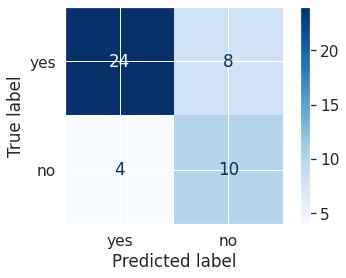

In [292]:
class_names = ['yes', 'no']
# Plot non-normalized confusion matrix
plot_confusion_matrix(svc_model, Xtest, Ytest,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 )
plt.show()

Random Forest

In [293]:
print('Random forest testing...')
rf_model = RandomForestClassifier(n_estimators=20, random_state=1,class_weight='balanced')
rf_model.fit(X_train.relation_matrix, Y_train.values.flatten())
    
rf_y_pred = rf_model.predict(Xtest)
print(f1_score(Ytest, rf_y_pred, average=None))
if (class_count <= 2):
  fpr, tpr, _ = roc_curve(Ytest, rf_y_pred.flatten())
  print(auc(fpr, tpr))
    


Random forest testing...
[0.86956522 0.60869565]
0.71875


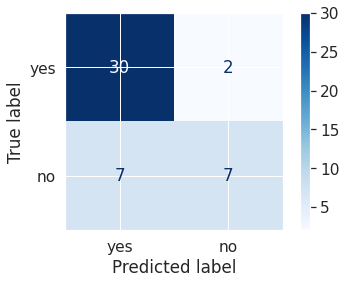

In [294]:
class_names = ['yes', 'no']
# Plot non-normalized confusion matrix
plot_confusion_matrix(rf_model, Xtest, Ytest,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 )
plt.show()

Refine with unexpected rules...
x is  ['a3@20-24', 'a7@left', 'a6@1', 'a5@no', 'a4@0-2', 'a2@ge40', 'a8@left_low', 'a9@no', 'a1@60-69']
condition ['a2@ge40', 'a4@3-5', 'a5@no', 'a9@no']
this item is present in itemset a2@ge40
condition ['a1@50-59', 'a2@ge40', 'a3@30-34', 'a6@3', 'a7@left', 'a9@no']
condition ['a2@ge40', 'a4@3-5', 'a5@no']
this item is present in itemset a2@ge40
condition ['a2@ge40', 'a4@3-5', 'a5@no', 'a8@left_low']
this item is present in itemset a2@ge40
condition ['a6@3', 'a7@right', 'a8@right_up', 'a9@no']
condition ['a2@ge40', 'a4@3-5', 'a6@3', 'a8@left_low']
this item is present in itemset a2@ge40
condition ['a2@ge40', 'a3@30-34', 'a4@3-5', 'a5@no']
this item is present in itemset a2@ge40
condition ['a1@50-59', 'a2@ge40', 'a3@30-34', 'a6@3', 'a9@no']
condition ['a1@50-59', 'a3@30-34', 'a6@3', 'a7@left', 'a9@no']
condition ['a3@25-29', 'a5@no', 'a6@3', 'a7@left']
condition ['a2@ge40', 'a3@30-34', 'a4@3-5']
this item is present in itemset a2@ge40
condition ['a4@3-5'

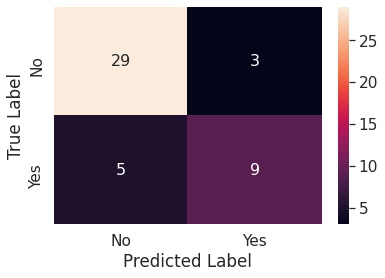

In [295]:
refine_with_unexpectedness(test_data_set, Y_train.item_dict, rf_y_pred, Ytest, refined_unexpected_rules, "RF", clus)

MLP

In [296]:
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
clf_mlp.fit(X_train.relation_matrix, Y_train.values.flatten())
    
mlp_y_pred = clf_mlp.predict(Xtest)
print(f1_score(Ytest, mlp_y_pred, average=None))
if (class_count <= 2):
  fpr, tpr, _ = roc_curve(Ytest, mlp_y_pred.flatten())
  print(auc(fpr, tpr))

[0.87671233 0.52631579]
0.6785714285714286


Refine with unexpected rules...
x is  ['a3@20-24', 'a7@left', 'a6@1', 'a5@no', 'a4@0-2', 'a2@ge40', 'a8@left_low', 'a9@no', 'a1@60-69']
condition ['a2@ge40', 'a4@3-5', 'a5@no', 'a9@no']
this item is present in itemset a2@ge40
condition ['a1@50-59', 'a2@ge40', 'a3@30-34', 'a6@3', 'a7@left', 'a9@no']
condition ['a2@ge40', 'a4@3-5', 'a5@no']
this item is present in itemset a2@ge40
condition ['a2@ge40', 'a4@3-5', 'a5@no', 'a8@left_low']
this item is present in itemset a2@ge40
condition ['a6@3', 'a7@right', 'a8@right_up', 'a9@no']
condition ['a2@ge40', 'a4@3-5', 'a6@3', 'a8@left_low']
this item is present in itemset a2@ge40
condition ['a2@ge40', 'a3@30-34', 'a4@3-5', 'a5@no']
this item is present in itemset a2@ge40
condition ['a1@50-59', 'a2@ge40', 'a3@30-34', 'a6@3', 'a9@no']
condition ['a1@50-59', 'a3@30-34', 'a6@3', 'a7@left', 'a9@no']
condition ['a3@25-29', 'a5@no', 'a6@3', 'a7@left']
condition ['a2@ge40', 'a3@30-34', 'a4@3-5']
this item is present in itemset a2@ge40
condition ['a4@3-5'

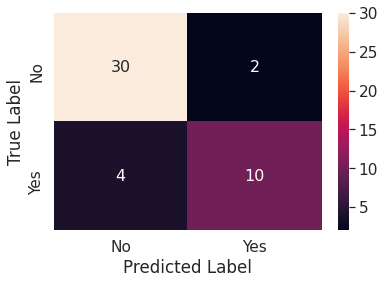

In [297]:
refine_with_unexpectedness(test_data_set, Y_train.item_dict, mlp_y_pred, Ytest, refined_unexpected_rules, "MLP", clus)

In [298]:
unique, counts = np.unique(Y_train.values, return_counts=True)

print(np.asarray((unique, counts)).T)

[[  0 169]
 [  1  71]]


In [299]:
Ytest

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [300]:
unique, counts = np.unique(Ytest, return_counts=True)

print(np.asarray((unique, counts)).T)

[[ 0 32]
 [ 1 14]]


Oversampling

In [305]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [306]:
oversample = RandomOverSampler(sampling_strategy='minority')

In [307]:
X_over, y_over = oversample.fit_resample(X_train.relation_matrix, Y_train.values.flatten())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [308]:
print(Counter(y_over))

Counter({0: 169, 1: 169})


In [309]:
print('svm testing with oversampling...')
svc_model = SVC()
svc_model.fit(X_over, y_over)

svm testing with oversampling...


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [310]:
svc_y_pred = svc_model.predict(Xtest)
print(f1_score(Ytest, svc_y_pred, average=None))
if (class_count <= 2):
  fpr, tpr, _ = roc_curve(Ytest, svc_y_pred.flatten())    
  print(auc(fpr, tpr))

[0.84848485 0.61538462]
0.7232142857142857


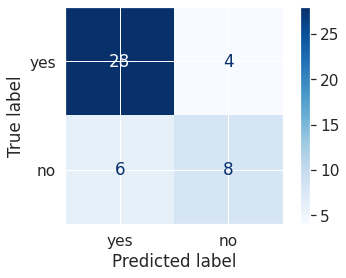

In [311]:
class_names = ['yes', 'no']
# Plot non-normalized confusion matrix
plot_confusion_matrix(svc_model, Xtest, Ytest,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 )
plt.show()

In [334]:
print('Random forest testing...')
rf_model = RandomForestClassifier(n_estimators=20, random_state=1,class_weight='balanced')
rf_model.fit(X_over, y_over)
    
rf_y_pred = rf_model.predict(Xtest)
print(f1_score(Ytest, rf_y_pred, average=None))
if (class_count <= 2):
  fpr, tpr, _ = roc_curve(Ytest, rf_y_pred.flatten())
  print(auc(fpr, tpr))
    


Random forest testing...
[0.86567164 0.64      ]
0.7388392857142857


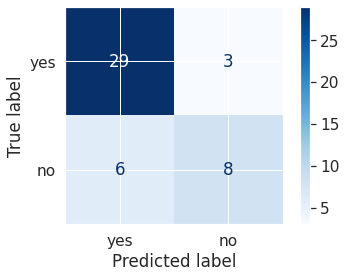

In [335]:
class_names = ['yes', 'no']
# Plot non-normalized confusion matrix
plot_confusion_matrix(rf_model, Xtest, Ytest,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 )
plt.show()

In [336]:
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
clf_mlp.fit(X_over, y_over)
    
mlp_y_pred = clf_mlp.predict(Xtest)
print(f1_score(Ytest, mlp_y_pred, average=None))
if (class_count <= 2):
  fpr, tpr, _ = roc_curve(Ytest, mlp_y_pred.flatten())
  print(auc(fpr, tpr))

[0.84210526 0.25      ]
0.5714285714285714


Undersampling

In [314]:
from imblearn.under_sampling import RandomUnderSampler

In [315]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [316]:
X_over, y_over = undersample.fit_resample(X_train.relation_matrix, Y_train.values.flatten())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [317]:
print(Counter(y_over))

Counter({0: 71, 1: 71})


In [318]:
print('svm testing with oversampling...')
svc_model = SVC()
svc_model.fit(X_over, y_over)

svm testing with oversampling...


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [319]:
svc_y_pred = svc_model.predict(Xtest)
print(f1_score(Ytest, svc_y_pred, average=None))
if (class_count <= 2):
  fpr, tpr, _ = roc_curve(Ytest, svc_y_pred.flatten())    
  print(auc(fpr, tpr))

[0.76666667 0.5625    ]
0.6808035714285714


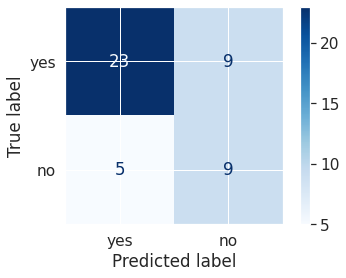

In [320]:
class_names = ['yes', 'no']
# Plot non-normalized confusion matrix
plot_confusion_matrix(svc_model, Xtest, Ytest,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 )
plt.show()

SMOTE

In [337]:
from imblearn.over_sampling import SMOTE

In [338]:
oversample = SMOTE()

In [339]:
X_over, y_over = oversample.fit_resample(X_train.relation_matrix, Y_train.values.flatten())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [340]:
print(Counter(y_over))

Counter({0: 169, 1: 169})


In [341]:
print('svm testing with oversampling...')
svc_model = SVC()
svc_model.fit(X_over, y_over)

svm testing with oversampling...


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [342]:
svc_y_pred = svc_model.predict(Xtest)
print(f1_score(Ytest, svc_y_pred, average=None))
if (class_count <= 2):
  fpr, tpr, _ = roc_curve(Ytest, svc_y_pred.flatten())    
  print(auc(fpr, tpr))

[0.8358209 0.56     ]
0.6875


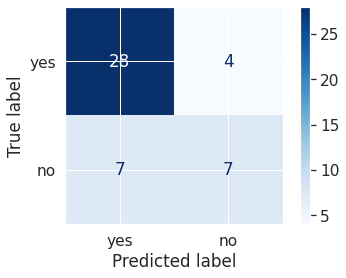

In [343]:
class_names = ['yes', 'no']
# Plot non-normalized confusion matrix
plot_confusion_matrix(svc_model, Xtest, Ytest,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 )
plt.show()

In [344]:
print('Random forest testing...')
rf_model = RandomForestClassifier(n_estimators=20, random_state=1,class_weight='balanced')
rf_model.fit(X_over, y_over)
    
rf_y_pred = rf_model.predict(Xtest)
print(f1_score(Ytest, rf_y_pred, average=None))
if (class_count <= 2):
  fpr, tpr, _ = roc_curve(Ytest, rf_y_pred.flatten())
  print(auc(fpr, tpr))
    


Random forest testing...
[0.86956522 0.60869565]
0.71875


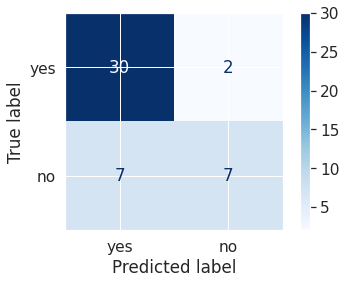

In [345]:
class_names = ['yes', 'no']
# Plot non-normalized confusion matrix
plot_confusion_matrix(rf_model, Xtest, Ytest,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 )
plt.show()

In [346]:
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
clf_mlp.fit(X_over, y_over)
    
mlp_y_pred = clf_mlp.predict(Xtest)
print(f1_score(Ytest, mlp_y_pred, average=None))
if (class_count <= 2):
  fpr, tpr, _ = roc_curve(Ytest, mlp_y_pred.flatten())
  print(auc(fpr, tpr))

[0.71875    0.35714286]
0.5379464285714286
